# Carnatic Beat Detection: what is that beat?


### Overview

This project develops an ML/AI classifier that identifies the Carnatic beat cycle (taalam) of a mridangam solo

### Goal

Given a clip of a drum solo, identify the taalam (beat cycle) in which it is performed.

In this notebook, we will do an <b>exploratory data analysis with only 2 taalam classes </b>: aadi talam (8-beat cycle) and misra-chapu talam (7-beat cycle), to investigate if Neural Nets can successfully classify these two types with the data at hand.

### Data

In [1]:
#!pip uninstall tensorflow
#!pip install tensorflow==2.12.0

In [2]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns
import os
import random
import math

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, accuracy_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier

import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import time

In [3]:
# Load the data
beatsDf1 = pd.read_csv("/content/Beats-3Class.csv")
beatsDf1.sample(7)

,FileName,Beat,1,2,3,4,5,6,7,8,...,491,492,493,494,495,496,497,498,499,500
77,MisraChapu-1025,M,0.002033,0.003775,0.006098,0.008420,0.012485,0.015970,0.022358,0.028165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,KhandaChapu2019,K,0.002031,0.005804,0.010157,0.013929,0.017702,0.020023,0.022345,0.025827,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,MisraChapu108,M,0.002618,0.005817,0.011635,0.014252,0.018034,0.022106,0.025887,0.034322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aadi-1001,A,0.000000,0.001448,0.003476,0.005214,0.006952,0.011008,0.014195,0.017961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,MisraChapu-1010,M,0.001159,0.003478,0.006957,0.010145,0.012464,0.022029,0.025217,0.026957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,KhandaChapu2024,K,0.004939,0.013074,0.016560,0.020046,0.021790,0.024114,0.025857,0.031668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,MisraChapu-1011,M,0.003187,0.006373,0.009560,0.011877,0.016512,0.018830,0.020568,0.029258,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
beatsDf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Columns: 502 entries, FileName to 500
dtypes: float64(500), object(2)
memory usage: 455.1+ KB


#### Cleanup 1:
We will set the number of numeric (time-lapse) features to be 250 since the majority of samples have approximately that many features. Drop features with names > 250.

In [5]:
# We will drop features with names 251 -- 500
featuresToDrop = []
for nn in range(251, 501):
    featuresToDrop.append(str(nn))

In [6]:
# Drop the columns above
beatsDf1 = beatsDf1.drop(featuresToDrop, axis = 1)

In [7]:
beatsDf1.sample(7)

,FileName,Beat,1,2,3,4,5,6,7,8,...,241,242,243,244,245,246,247,248,249,250
3,Aadi-1003,A,0.003196,0.006392,0.009587,0.028181,0.031668,0.035445,0.038640,0.049680,...,0.938698,0.941894,0.944509,0.946833,0.948286,0.949739,0.951772,0.957873,0.961650,0.964265
28,Aadi-1028,A,0.000290,0.002899,0.005507,0.008696,0.011304,0.013913,0.016522,0.018261,...,0.885507,0.891304,0.898261,0.900290,0.901739,0.906087,0.909275,0.912754,0.914783,0.916232
49,Palghat mani iyer Aadi Taalam - 102,A,0.000872,0.004070,0.006977,0.010465,0.014244,0.018314,0.021512,0.024419,...,0.887209,0.890407,0.891860,0.893895,0.896221,0.899128,0.902326,0.905814,0.907849,0.911047
48,Palghat mani iyer Aadi Taalam - 101,A,0.018044,0.022992,0.028231,0.032305,0.036088,0.039872,0.045402,0.047439,...,0.968568,0.973225,0.978754,0.983411,0.988650,0.992724,0.997090,NaN,NaN,NaN
57,Aadi-1,A,0.000293,0.001755,0.004681,0.009070,0.011410,0.013751,0.017262,0.034816,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,Aadi-1029,A,0.001165,0.002621,0.004950,0.008445,0.011066,0.014560,0.017764,0.021549,...,0.724520,0.728014,0.730635,0.735585,0.739662,0.741701,0.744030,0.747816,0.751310,0.754805
100,MishraChapu2000,M,0.000868,0.002604,0.004340,0.006655,0.008391,0.012442,0.014178,0.016204,...,0.748264,0.751447,0.755787,0.760706,0.765046,0.768519,0.771123,0.773438,0.777199,0.780382


In [8]:
beatsDf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Columns: 252 entries, FileName to 250
dtypes: float64(250), object(2)
memory usage: 228.5+ KB


#### Cleanup 2:
Drop rows with NaNs. These are really short clips and probably will not contain sufficient data for analysis. There is no meaningful way to fill in missing values.

In [9]:
beatsDf_full = beatsDf1.dropna()

In [10]:
beatsDf_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 115
Columns: 252 entries, FileName to 250
dtypes: float64(250), object(2)
memory usage: 199.6+ KB


In [11]:
beatsDf_full.sample(5)

,FileName,Beat,1,2,3,4,5,6,7,8,...,241,242,243,244,245,246,247,248,249,250
3,Aadi-1003,A,0.003196,0.006392,0.009587,0.028181,0.031668,0.035445,0.038640,0.049680,...,0.938698,0.941894,0.944509,0.946833,0.948286,0.949739,0.951772,0.957873,0.961650,0.964265
54,Palghat raghu misra chapu - 103,M,0.001448,0.004922,0.011581,0.014765,0.018240,0.025188,0.028662,0.031847,...,0.940359,0.943544,0.946149,0.948176,0.952808,0.955414,0.962362,0.969021,0.976259,0.983497
66,MisraChapu-1014,M,0.003198,0.006977,0.009012,0.011919,0.015988,0.020058,0.024419,0.032558,...,0.846802,0.848837,0.852035,0.854360,0.858140,0.861337,0.863372,0.865407,0.867733,0.871221
8,Aadi-1008,A,0.000873,0.003201,0.006112,0.008149,0.012515,0.016007,0.019499,0.024156,...,0.855355,0.858847,0.862340,0.864377,0.870780,0.876601,0.880384,0.882712,0.884750,0.888242
105,KhandaChapu107,K,0.000290,0.002319,0.005507,0.008406,0.010435,0.015072,0.017101,0.020580,...,0.793913,0.797391,0.802029,0.803768,0.810145,0.813623,0.816522,0.819710,0.823188,0.826087


In [12]:
# Drop the "FileName" column
beatsDf_full = beatsDf_full.drop("FileName", axis = 1)

In [13]:
beatsDf_full.value_counts('Beat')

Beat
A    36
M    34
K    31
Name: count, dtype: int64

In [14]:
# Use a 2-class dataset to test Neural Network performance (accuracy) compared to traditional classifiers.
# Drop rows with Beat = 'K'
beatsDf_2Class = beatsDf_full.drop(beatsDf_full[beatsDf_full.Beat == 'K'].index)

In [15]:
beatsDf_2Class.value_counts('Beat')

Beat
A    36
M    34
Name: count, dtype: int64

### Split data into training and test sets

In [16]:
# Data: indepndent and dependent variables
X = beatsDf_2Class.drop(['Beat'], axis = 1)

# target: the Beat type
labelEnc = LabelEncoder()
y = labelEnc.fit_transform(beatsDf_2Class['Beat'])

In [17]:
print(y[:5])

[0 0 0 0 0]


In [18]:
y_ohe = to_categorical(y)

print(y_ohe[:5])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [19]:
rand_state = 44
# Data, split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rand_state)

In [20]:
# Scale X
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
y_ohe_train = to_categorical(y_train)
y_ohe_test = to_categorical(y_test)

### Models.
We iterate through a set of Neural Net models, varying the number of layers (1 .. 8) and the number of nodes in each layer (30 .. 90). We  record the performance of each model and examine the results for accuracy in the validation data set.

In [22]:
def create_Seq_model(nLayers, nNodes, nClasses):
  modelName = 'Model_' + str(nLayers) + '-layers_' + str(nNodes) + '-nodes_' +  str(nClasses) + '-classes'
  model = Sequential(name = modelName)
  # Hidden layers
  for ii in range(nLayers):
    model.add(Dense(nNodes, activation="relu"))
  # The final output layer
  model.add(Dense(nClasses, activation="softmax"))
  return model


In [23]:
model_results = []

numClasses = 2
maxNumLayers = 8
numEpochs = 100
for numLay in range(2, maxNumLayers + 1):
  for numNodes in range(30, 91, 30):
    mm = create_Seq_model(nLayers = numLay, nNodes = numNodes, nClasses = numClasses)
    mm.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'])
    history_mm = mm.fit(X_train_scaled, y_ohe_train, epochs = numEpochs, verbose = 0, batch_size = 3, validation_data = (X_test_scaled, y_ohe_test))

    accuracies_mm = history_mm.history['accuracy']
    validation_accuracies_mm = history_mm.history['val_accuracy']
    model_results.append({
            'Layers': numLay,
            'Nodes': numNodes,
            'fit_accuracy': accuracies_mm[-1],
            'validation_accuracy': validation_accuracies_mm[-1]
            })


In [24]:
# Dataframe out of the results
modelResultsDf = pd.DataFrame(model_results)
modelResultsDf

,Layers,Nodes,fit_accuracy,validation_accuracy
0,2,30,0.982143,0.571429
1,2,60,0.982143,0.571429
2,2,90,0.982143,0.642857
3,3,30,0.964286,0.714286
4,3,60,1.000000,0.642857
5,3,90,0.964286,0.571429
6,4,30,0.982143,0.642857
7,4,60,0.964286,0.571429
8,4,90,0.946429,0.714286
9,5,30,0.982143,0.500000


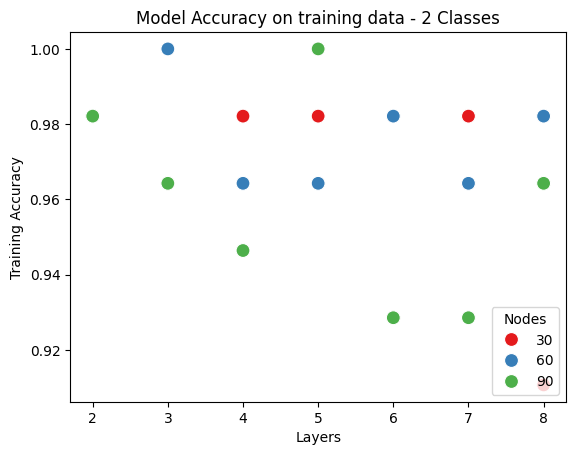

In [25]:
plt1 = sns.scatterplot(data=modelResultsDf, x='Layers', y='fit_accuracy', hue='Nodes', palette = 'Set1', s = 100)
plt1.set_title('Model Accuracy on training data - 2 Classes')
plt1.set(ylabel='Training Accuracy')
sns.move_legend(plt1, loc='lower right')
plt.show()


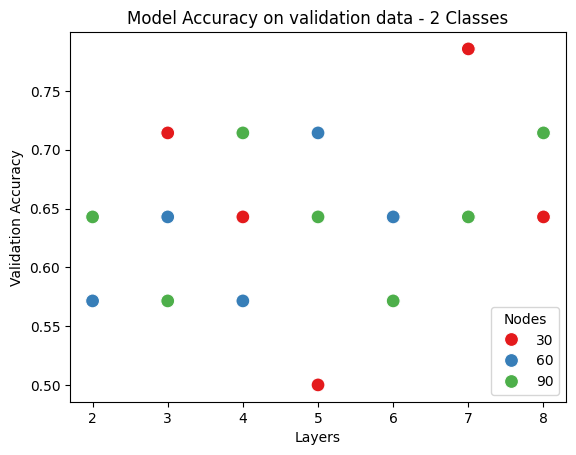

In [26]:
plt2 = sns.scatterplot(data=modelResultsDf, x='Layers', y='validation_accuracy', hue='Nodes', palette = 'Set1', s = 100)
plt2.set_title('Model Accuracy on validation data - 2 Classes')
plt2.set(ylabel='Validation Accuracy')
sns.move_legend(plt2, loc='lower right')
plt.show()


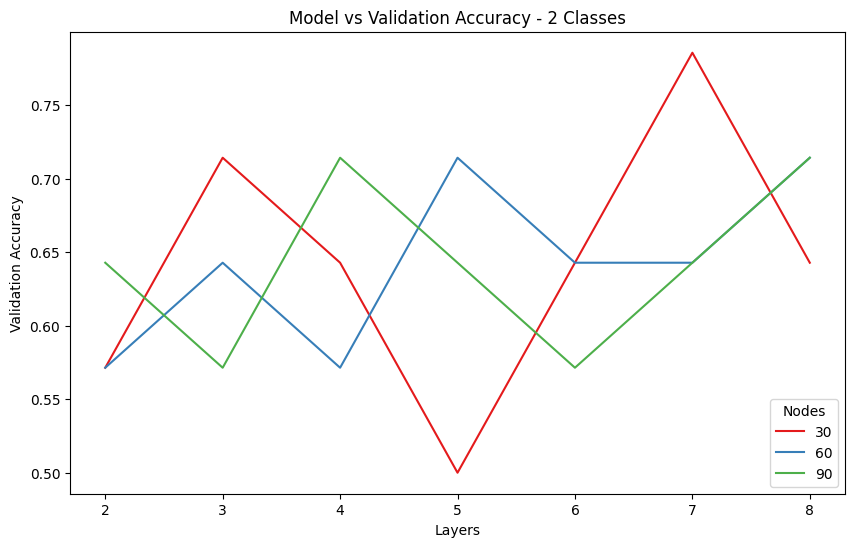

In [27]:
figg, axx = plt.subplots(figsize=(10, 6))
plt4 = sns.lineplot(data=modelResultsDf, x='Layers', y='validation_accuracy', hue='Nodes', palette = 'Set1')
sns.move_legend(plt4, loc='lower right')
plt4.set_title('Model vs Validation Accuracy - 2 Classes')
plt4.set(xlabel='Layers', ylabel='Validation Accuracy')
plt.show()
plt4.get_figure().savefig("/content/Images/model_valid_accuracy_line_NN_2.png")

### Observations
We observe that most models don't perform much better than random chance (where you would expect an accuracy of 0.5). However, some models example (layers = 7, nodes = 30) have an  accuracy of close to 80%. This is reasonable for such a small dataset.

### Number of epochs
We select a moderately sized model (3 layers, 3o nodes) and profile the accuracy as we increase the number of epochs.

In [28]:
epoch_results = []
for numEpochs in range(100, 1001, 100):
  mm = create_Seq_model(nLayers = 3, nNodes = 30, nClasses = numClasses)
  mm.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'])
  history_mm = mm.fit(X_train_scaled, y_ohe_train, epochs = numEpochs, verbose = 0, batch_size = 3, validation_data = (X_test_scaled, y_ohe_test))

  accuracies_mm = history_mm.history['accuracy']
  validation_accuracies_mm = history_mm.history['val_accuracy']
  epoch_results.append({
          'Epochs': numEpochs,
          'fit_accuracy': accuracies_mm[-1],
          'validation_accuracy': validation_accuracies_mm[-1]
          })


In [29]:
# Dataframe out of the results
epochResultsDf = pd.DataFrame(epoch_results)
epochResultsDf

,Epochs,fit_accuracy,validation_accuracy
0,100,0.946429,0.571429
1,200,1.000000,0.642857
2,300,1.000000,0.785714
3,400,1.000000,0.428571
4,500,1.000000,0.642857
5,600,1.000000,0.642857
6,700,1.000000,0.500000
7,800,1.000000,0.714286
8,900,1.000000,0.571429
9,1000,1.000000,0.785714


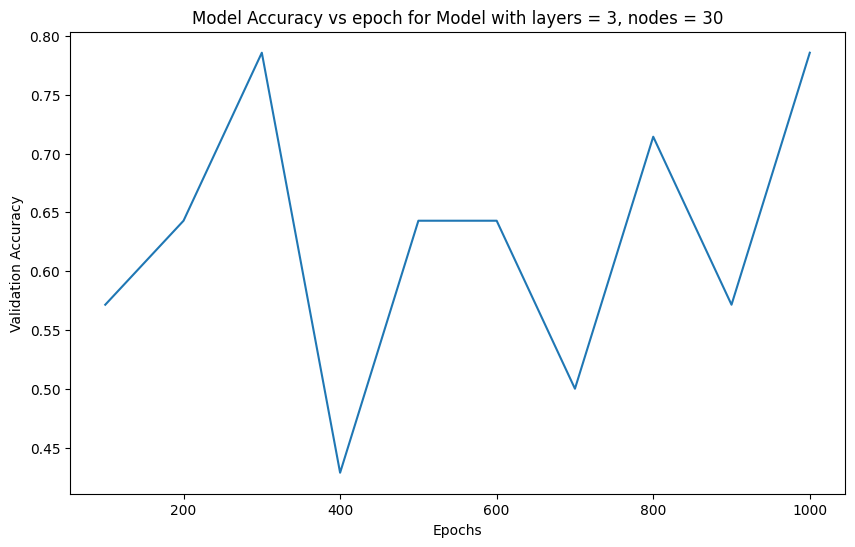

In [30]:
figg, axx = plt.subplots(figsize=(10, 6))
plt3 = sns.lineplot(data=epochResultsDf, x='Epochs', y='validation_accuracy')
plt3.set_title('Model Accuracy vs epoch for Model with layers = 3, nodes = 30')
plt3.set(ylabel='Validation Accuracy')
plt.show()
plt3.get_figure().savefig("/content/Images/model_accuracy_vs_epoch_NN_2.png")

### Observation
We see that epoch dependence is already asymptotic, so epoch = 100 is a reasonable choice.